# 주식 시장 가격 예측

## DJIA 데이터셋 이해
    - DJIA 지수는 특정 날짜의 주식 시장 움직임에 대한 전반적인 아이디어 제공
    1. Date: YYYY-MM-DD 형식의 거래일자
    2. Open: 시장이 열린 시점의 가격으로 특정 거래일에 대한 DJIA 지수의 시가
    3. High: 특정 거래일에 대한  DJIA 지수의 고가
    4. Low: 특정 거래일에 대한 DJIA 지수의 저가
    5. Close: 거래일이 끝나는 시점의 DJIA 지수의 가격, 즉 종가
    6. Adj Close: 수정 종가는 종가를 시작 지점으로 여기고 여기에 주식 분할 및 신주 배당과 같은 요인을
       고려해 조정한 가격
       DJIA 지수의 진정한 반영
    7. Volume: 거래량 값은 특정 거래일에 거래소에서 거래되는 지수의 개수

## 뉴욕타임즈 뉴스 기사 데이터셋
    - 뉴스가 주가에 어떻게 영향을 미치는지를 알아내는 데 도움
    - JSON 형식
    1. type_of_material: 특정 뉴스 기사가 블로그, 뉴스 기사, 분석 등 특정 뉴스에서 파생되었음을 나타낸다.
    2. headlines: 두 개의 하위 데이터 특성이 있다.
        1) main(주제): 뉴스의 실제 헤드라인을 포함
        2) kicker(부제): 기사의 요점을 전달
    3. pub_date: 뉴스 기사의 발행 일자를 나타낸다.
    4. section_name: 뉴스 기사의 분야를 제공
    5. news_desk: 뉴스 분야를 나타낸다.
                  section_name이 응답이 없을때 참조
              

## New York Times data API

In [2]:
import numpy as np
import csv, json
import pandas as pd

## Prepare DJIA training dataset

In [19]:
with open('./data/DJIA_data.csv', mode='r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    data_list = list(spamreader)

header = data_list[0]
data_list = data_list[1:]
data_list = np.asarray(data_list)

selected_data = data_list[:, [0, 4, 5]]
df = pd.DataFrame(data=selected_data[0:, 1:],
                 index=selected_data[0:, 0],
                 columns=['close', 'adj close'],
                 dtype='float64')


In [21]:
df.head()

,close,adj close
2006-12-28,12501.519531,12501.519531
2006-12-29,12463.150391,12463.150391
2007-01-03,12474.519531,12474.519531
2007-01-04,12480.690430,12480.690430
2007-01-05,12398.009766,12398.009766


## Basic Data analysis for DJIA dataset

In [28]:
df1 = df
idx = pd.date_range('12-29-2006', '12-31-2016')

df1.index = pd.DatetimeIndex(df1.index)
df1 = df1.reindex(idx, fill_value=np.NaN)
df1

,close,adj close
2006-12-29,12463.150391,12463.150391
2006-12-30,NaN,NaN
2006-12-31,NaN,NaN
2007-01-01,NaN,NaN
2007-01-02,NaN,NaN
...,...,...
2016-12-27,19945.039063,19945.039063
2016-12-28,19833.679688,19833.679688
2016-12-29,19819.779297,19819.779297
2016-12-30,NaN,NaN


In [30]:
interpolated_df = df1.interpolate()
interpolated_df = interpolated_df[3:]

In [31]:
interpolated_df.head()

,close,adj close
2007-01-01,12469.971875,12469.971875
2007-01-02,12472.245703,12472.245703
2007-01-03,12474.519531,12474.519531
2007-01-04,12480.690430,12480.690430
2007-01-05,12398.009766,12398.009766


## Prepare New York Times news dataset
    1. 발행 일자를 YYYY-MM-DD 형식으로 변환
    2. 뉴스 기사를 해당 분야에 맞게 선별
    3. 필터 특징을 구현하고 데이터셋을 병합
    4. 병합된 데이터셋을 pickle 파일 형식으로 저장
        - New York Times 데이터 api 문제로 제공해주는 pickle 파일을 사용

## 특징 공학
    1. 데이터 적재
    2. 소규모 전처리
    3. 특징 선택
    4. 정서 분석

## 데이터 적재

In [55]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
df_stocks = pd.read_pickle('./data/pickled_ten_year_filtered_lead_para.pkl')

In [57]:
df_stocks.head()

,close,adj close,articles
2007-01-01,12469.971875,12469.971875,. What Sticks from '06. Somalia Orders Islamis...
2007-01-02,12472.245703,12472.245703,. Heart Health: Vitamin Does Not Prevent Death...
2007-01-03,12474.519531,12474.519531,. Google Answer to Filling Jobs Is an Algorith...
2007-01-04,12480.690430,12480.690430,. Helping Make the Shift From Combat to Commer...
2007-01-05,12398.009766,12398.009766,. Rise in Ethanol Raises Concerns About Corn a...


## 소규모 전처리
    1. 수정 종가를 정수형식으로 변환
    2. 뉴스 헤드라인에서 가장 왼ㅉ고에 놓인 점(,)을 제거

In [58]:
df_stocks['prices'] = df_stocks['adj close'].apply(np.int64)

In [63]:
df_stocks = df_stocks[['prices', 'articles']]

In [64]:
df_stocks.head()

,prices,articles
2007-01-01,12469,. What Sticks from '06. Somalia Orders Islamis...
2007-01-02,12472,. Heart Health: Vitamin Does Not Prevent Death...
2007-01-03,12474,. Google Answer to Filling Jobs Is an Algorith...
2007-01-04,12480,. Helping Make the Shift From Combat to Commer...
2007-01-05,12398,. Rise in Ethanol Raises Concerns About Corn a...


In [65]:
df_stocks['articles'] = df_stocks['articles'].map(lambda x: x.lstrip('.-'))

<ipython-input-65-1e2d08f1eda5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stocks['articles'] = df_stocks['articles'].map(lambda x: x.lstrip('.-'))


In [68]:
df_stocks.head()

,prices,articles
2007-01-01,12469,What Sticks from '06. Somalia Orders Islamist...
2007-01-02,12472,Heart Health: Vitamin Does Not Prevent Death ...
2007-01-03,12474,Google Answer to Filling Jobs Is an Algorithm...
2007-01-04,12480,Helping Make the Shift From Combat to Commerc...
2007-01-05,12398,Rise in Ethanol Raises Concerns About Corn as...


In [100]:
df = df_stocks[['prices']].copy()
df.head()

,prices
2007-01-01,12469
2007-01-02,12472
2007-01-03,12474
2007-01-04,12480
2007-01-05,12398


## 정서 분석

In [113]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import unicodedata
sid = SentimentIntensityAnalyzer()
for date, row in df_stocks.T.iteritems():
    try:
        sentence = unicodedata.normalize('NFKD', df_stocks.loc[date, 'articles']).encode('ascii','ignore').decode('utf8')
        ss = sid.polarity_scores(sentence)
        df.at[date, 'compound'] = ss['compound']
        df.at[date, 'neg'] = ss['neg']
        df.at[date, 'neu'] = ss['neu']
        df.at[date, 'pos'] = ss['pos']
    except TypeError:
        print(df_stocks.loc[date, 'articles'])
        print(date)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\wltjd\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [114]:
df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,-0.9814,0.159,0.749,0.093
2007-01-02,12472,-0.8871,0.118,0.783,0.099
2007-01-03,12474,-0.9993,0.198,0.734,0.067
2007-01-04,12480,-0.9982,0.131,0.806,0.062
2007-01-05,12398,-0.9901,0.124,0.794,0.082


## 머신러닝 모델 훈련
    1. 훈련 데이터셋과 테스트 데이터셋으로 분할
    2. 훈련 및 테스트 데이터셋의 예측 레이블 분할
    3. 정서 점수를 넘파이 배열로 변환
    4. 머신러닝 모델 훈련

In [115]:
# 훈련 데이터셋과 테스트 데이터셋으로 분할
# 데이터는 10년분으로 훈련 데이터는 8년분(2007~2014)
# 테스트 데이터는 2년분(2015~2016)으로 분할하여 사용
train_start_date = '2007-01-01'
train_end_date = '2014-12-31'
test_start_date = '2015-01-01'
test_end_date = '2016-12-31'
train = df.loc[train_start_date:train_end_date]
test = df.loc[test_start_date:test_end_date]

In [117]:
# 훈련 데이터셋 및 테스트 데이터셋의 예측 레이블 분할
# 예측 레이블: prices(수정종가)
y_train = pd.DataFrame(train['prices'])
y_test = pd.DataFrame(test['prices'])

In [119]:
# 정서 점수를 넘파이 배열로 변환
sentiment_score_list = []
for date, row in train.T.iteritems():
    sentiment_score = np.array([df.loc[date, 'neg'], df.loc[date, 'pos']])
    sentiment_score_list.append(sentiment_score)
numpy_df_train = np.asarray(sentiment_score_list)

In [120]:
sentiment_score_list = []
for date, row in test.T.iteritems():
    sentiment_score = np.array([df.loc[date, 'neg'], df.loc[date, 'pos']])
    sentiment_score_list.append(sentiment_score)
numpy_df_test = np.asarray(sentiment_score_list)

In [123]:
# 머신러닝 모델 훈련
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestRegressor()
rf.fit(numpy_df_train, y_train)

C:\Users\wltjd\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
<ipython-input-123-bb2d334b00f4>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(numpy_df_train, y_train)


RandomForestRegressor()

## 테스트 계량
    1. 기본 테스트 계량
        - 점수 함수(score function)는 제곱 오차(squared error)를 합한 값의 계수
        - (1 - (u/v))
        - u: 잔차 제곱 합(residual sum of squares)
            -> (Y.true - Y.pred)**2.sum()
        - v: 전체 제곱 합(total sum of squares)
            -> (Y.true - Y.mean)**2.sum()
    2. 시각화 접근법

## 기준 모델 테스트
    1. 출력 생성과 해석
    2. 정확도 점수 생성
    3. 출력 시각화

In [129]:
# 출력 생성과 해석
prediction, bias, contributions = ti.predict(rf, numpy_df_test)
prediction[:5]

array([[10952.86      ],
       [10599.9075    ],
       [13967.98916667],
       [13065.92083333],
       [12253.52      ]])

In [130]:
# 정확도 점수 생성
# 시각화를 통해 문제를 파악
rf.score(numpy_df_test, y_test)

-43.31739834614796

In [131]:
# 출력 시각화
idx = pd.date_range(test_start_date, test_end_date)
predictions_df = pd.DataFrame(data=prediction[0:], index=idx, columns=['prices'])

In [135]:
predictions_df.head()

,prices
2015-01-01,10952.860000
2015-01-02,10599.907500
2015-01-03,13967.989167
2015-01-04,13065.920833
2015-01-05,12253.520000


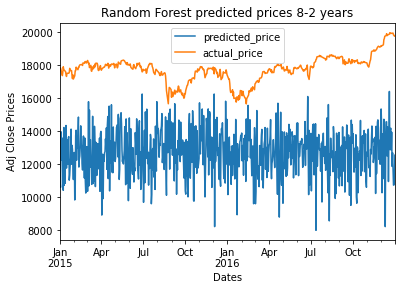

In [136]:
ax = predictions_df.rename(columns=
                          {"prices": "predicted_price"}).plot(title=
                                                             'Random Forest predicted prices 8-2 years')
ax.set_xlabel('Dates')
ax.set_ylabel('Adj Close Prices')
fig = y_test.rename(columns={"prices": 'actual_price'}).plot(ax=ax).get_figure()

## 기존 접근법의 문제점 탐구
    1. 조정
        - 실제 가격과 예측 가격이 서로 일치하지 않는다
        - 데이터셋의 평균값을 고려하여 주가를 조정할 것이다.
    2. 평활화
        - 평활화(smoothing)기술을 적용하지 않았다.
        - 평활화을 위해 지수 가중 이동 평균 기법을 적용한다.
        - 해당 기법은 데이터셋의 분산을 조정한다.
    3. 그 밖의 머신러닝 알고리즘 시도

## 개선 접근법
    1. 조정 기반 접근법
        - 실제 값의 평균을 구하고 예측 값의 평균을 구해 두 값의 차를 구한다.
        - 해당 차이 값을 테스트 데이터셋에 추가하여 조정한다.
    2. 평활화 기반 접근법
        - EWMA(지수가중이동평균)을 사용

In [141]:
# 조정
from datetime import datetime, timedelta
temp_date = test_start_date
average_last_5_days_test = 0
total_days = 10
for i in range(total_days):
    average_last_5_days_test += test.loc[temp_date, 'prices']
    temp_date = datetime.strptime(temp_date, '%Y-%m-%d').date()
    difference = temp_date + timedelta(days=1)
    temp_date = difference.strftime('%Y-%m-%d')
average_last_5_days_test = average_last_5_days_test / total_days
print(average_last_5_days_test)

temp_date = test_start_date
average_upcoming_5_days_predicted = 0
for i in range(total_days):
    average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
    temp_date = datetime.strptime(temp_date, '%Y-%m-%d').date()
    difference = temp_date + timedelta(days=1)
    temp_date = difference.strftime('%Y-%m-%d')
average_upcoming_5_days_predicted = average_upcoming_5_days_predicted / total_days
print(average_upcoming_5_days_predicted)

difference_test_predicted_prices = average_last_5_days_test - average_upcoming_5_days_predicted
print(difference_test_predicted_prices)

17679.9
12081.751516666667
5598.148483333334


In [142]:
predictions_df['prices'] = predictions_df['prices'] + difference_test_predicted_prices
predictions_df.head()

,prices
2015-01-01,16551.008483
2015-01-02,16198.055983
2015-01-03,19566.137650
2015-01-04,18664.069317
2015-01-05,17851.668483


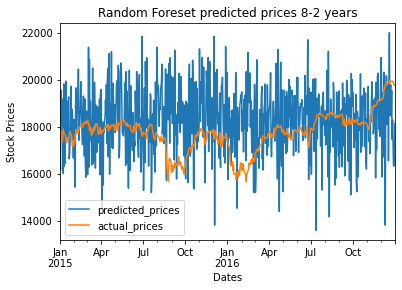

In [145]:
ax = predictions_df.rename(columns={'prices' : 'predicted_prices'}).plot(title="Random Foreset predicted prices 8-2 years")
ax.set_xlabel('Dates')
ax.set_ylabel('Stock Prices')
y_test.rename(columns={'prices':'actual_prices'}).plot(ax=ax)

In [147]:
# 평활화
predictions_df['ewma'] = predictions_df['prices'].ewm(span=60).mean()

In [148]:
predictions_df.head()

,prices,ewma
2015-01-01,16551.008483,16551.008483
2015-01-02,16198.055983,16371.590963
2015-01-03,19566.137650,17472.128711
2015-01-04,18664.069317,17785.175863
2015-01-05,17851.668483,17799.375478


In [149]:
predictions_df['actual_value'] = test['prices']
predictions_df['actual_value_ewma'] = predictions_df['actual_value'].ewm(span=60).mean()

In [150]:
predictions_df.head()

,prices,ewma,actual_value,actual_value_ewma
2015-01-01,16551.008483,16551.008483,17828,17828.000000
2015-01-02,16198.055983,16371.590963,17832,17830.033333
2015-01-03,19566.137650,17472.128711,17722,17792.815295
2015-01-04,18664.069317,17785.175863,17612,17745.326592
2015-01-05,17851.668483,17799.375478,17501,17693.150223


In [151]:
predictions_df.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actural_price']

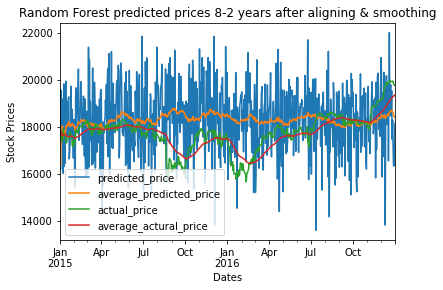

In [152]:
predictions_plot = predictions_df.plot(title='Random Forest predicted prices 8-2 years after aligning & smoothing')
predictions_plot.set_xlabel('Dates')
predictions_plot.set_ylabel('Stock Prices')
fig = predictions_plot.get_figure()

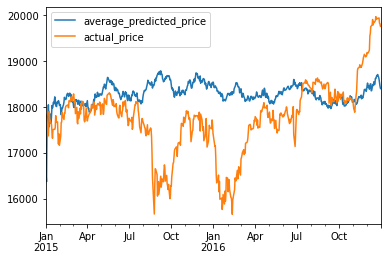

In [154]:
predictions_df_average = predictions_df[['average_predicted_price', 'actual_price']]
predictions_plot = predictions_df_average.plot()
fig = predictions_plot.get_figure()

In [164]:
def offset_value(test_start_date, test, predictions_df):
    temp_date = test_start_date
    average_last_5_days_test = 0
    average_upcoming_5_days_predicted = 0
    total_days = 10
    for i in range(total_days):
        average_last_5_days_test += test.loc[temp_date, 'prices']
        temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
        difference = temp_date + timedelta(days=1)
        temp_date = difference.strftime('%Y-%m-%d')
    average_last_5_days_test = average_last_5_days_test / total_days

    temp_date = test_start_date
    for i in range(total_days):
        average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
        temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
        difference = temp_date + timedelta(days=1)
        temp_date = difference.strftime('%Y-%m-%d')
    average_upcoming_5_days_predicted = average_upcoming_5_days_predicted / total_days
    difference_test_predicted_prices = average_last_5_days_test - average_upcoming_5_days_predicted
    return difference_test_predicted_prices

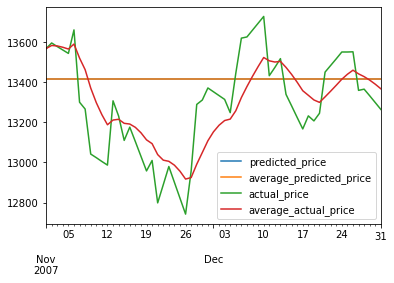

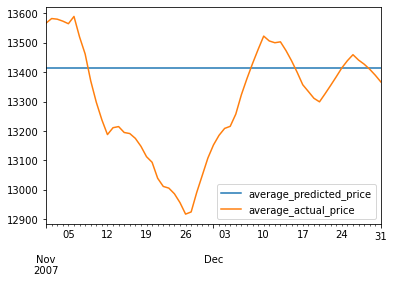

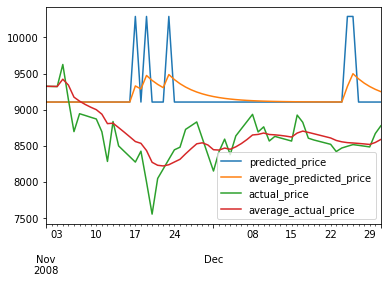

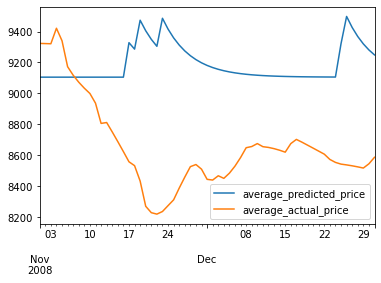

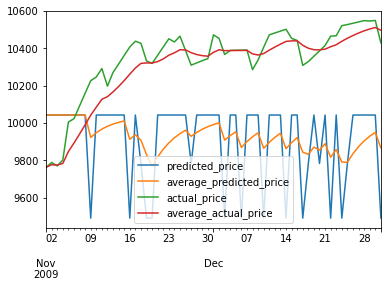

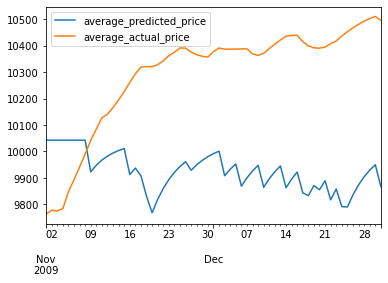

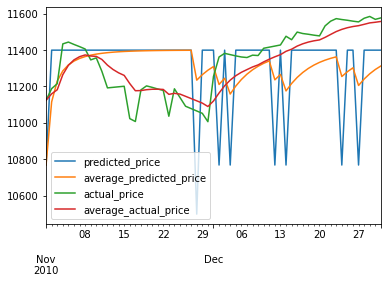

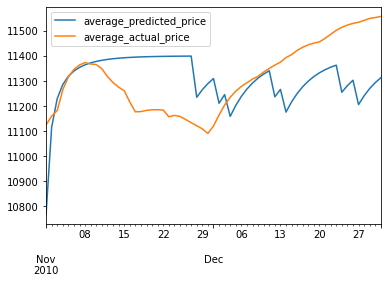

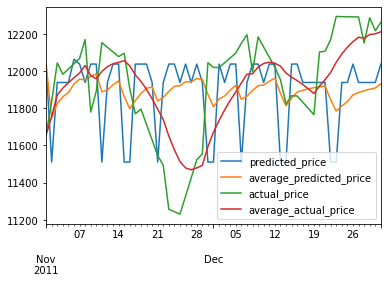

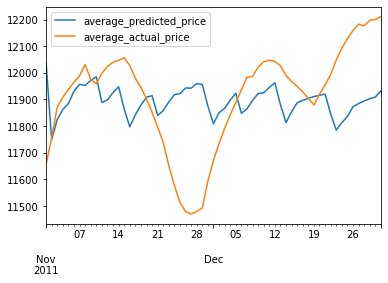

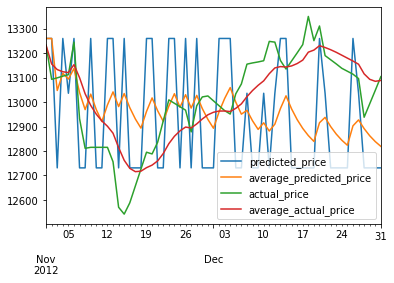

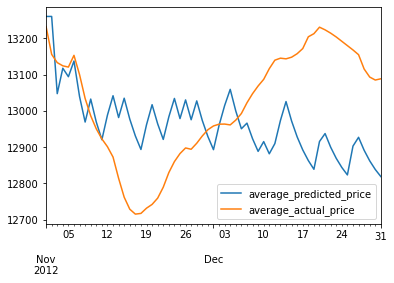

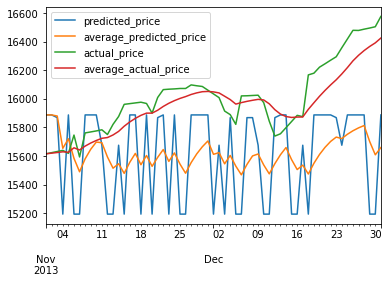

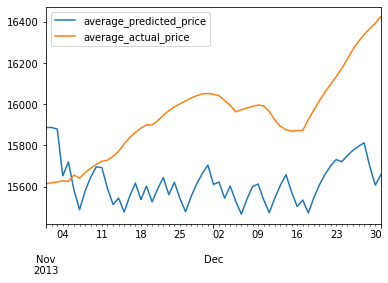

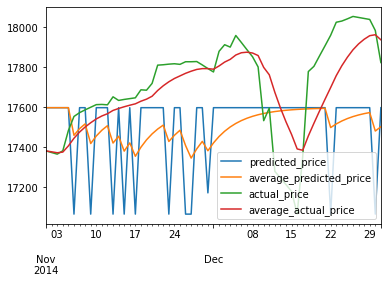

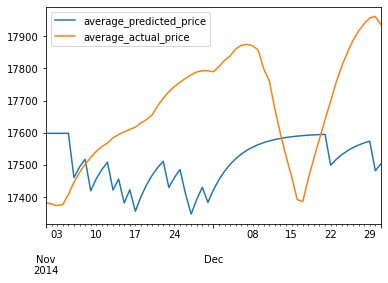

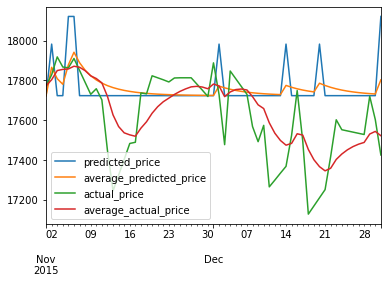

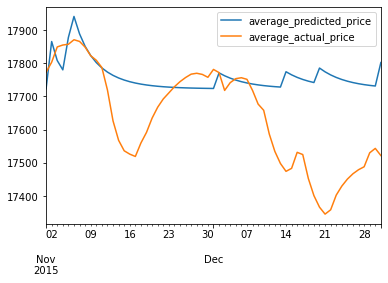

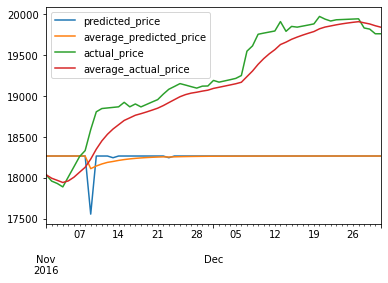

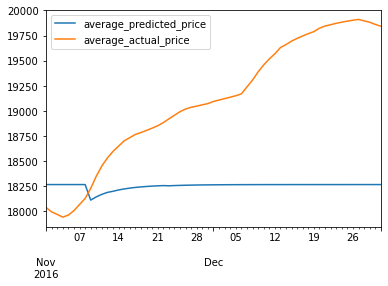

In [178]:
# 로지스틱 회귀
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from datetime import datetime, timedelta

years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
prediction_list = []
for year in years:
    # Splitting the training and testing data
    train_start_date = str(year) + '-01-01'
    train_end_date = str(year) + '-10-31'
    test_start_date = str(year) + '-11-01'
    test_end_date = str(year) + '-12-31'
    train = df.loc[train_start_date : train_end_date]
    test = df.loc[test_start_date:test_end_date]
    
    # Calculating the sentiment score
    sentiment_score_list = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list)
    sentiment_score_list = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list)
    
    # Generating models
    lr = LogisticRegression()
    lr.fit(numpy_df_train, train['prices'])
    
    prediction = lr.predict(numpy_df_test)
    prediction_list.append(prediction)
  
    #print train_start_date + ' ' + train_end_date + ' ' + test_start_date + ' ' + test_end_date
    idx = pd.date_range(test_start_date, test_end_date)
    #print year
    predictions_df_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
    
    difference_test_predicted_prices = offset_value(test_start_date, test, predictions_df_list)
    # Adding offset to all the advpredictions_df price values
    predictions_df_list['prices'] = predictions_df_list['prices'] + difference_test_predicted_prices
    predictions_df_list

    # Smoothing the plot
    predictions_df_list['ewma'] = predictions_df_list['prices'].ewm(span=10).mean()
    predictions_df_list['actual_value'] = test['prices']
    predictions_df_list['actual_value_ewma'] = predictions_df_list["actual_value"].ewm(span=10).mean()
    # Changing column names
    predictions_df_list.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
    predictions_df_list.plot()
    predictions_df_list_average = predictions_df_list[['average_predicted_price', 'average_actual_price']]
    predictions_df_list_average.plot()

C:\Users\wltjd\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\wltjd\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\wltjd\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\wltjd\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\wltjd\anaconda3\lib\site-packages\sklearn\neural_network\_multi

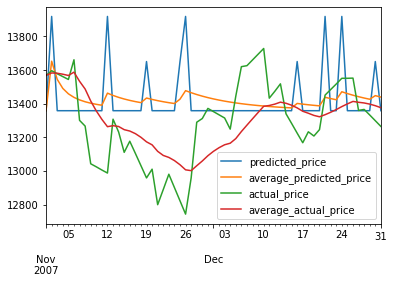

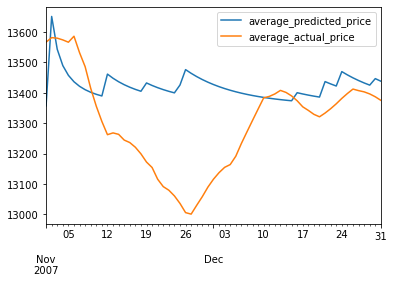

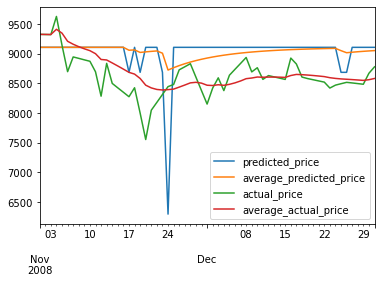

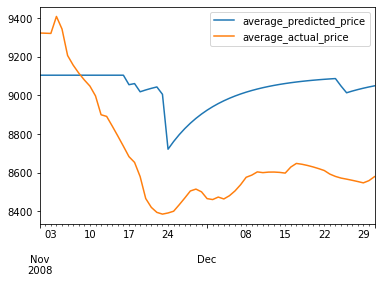

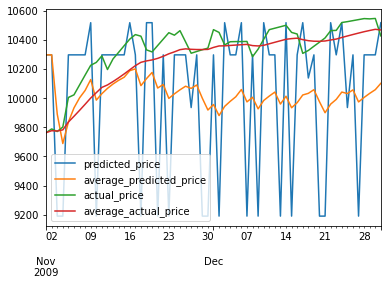

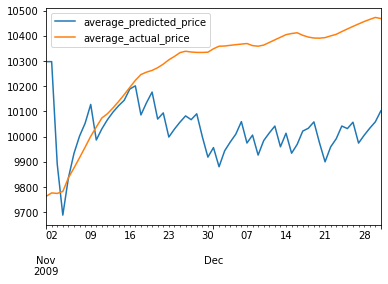

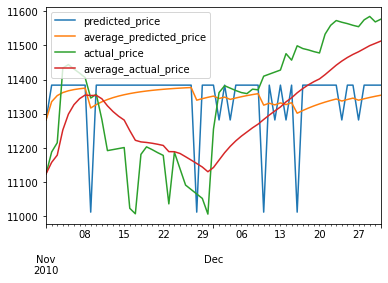

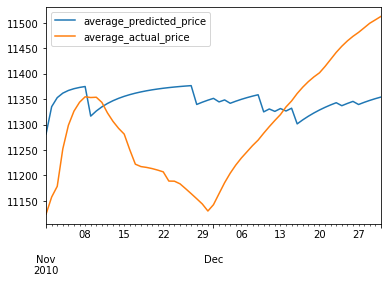

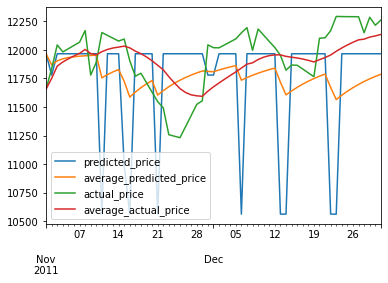

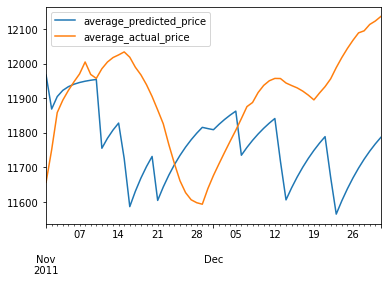

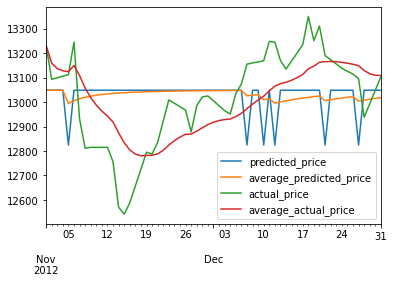

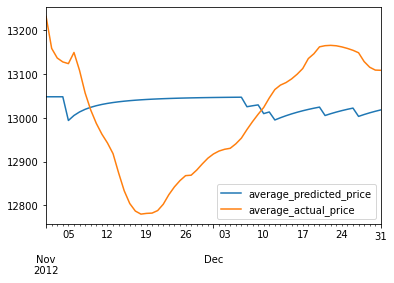

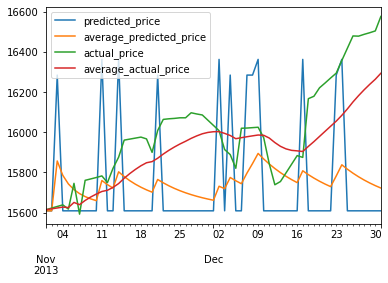

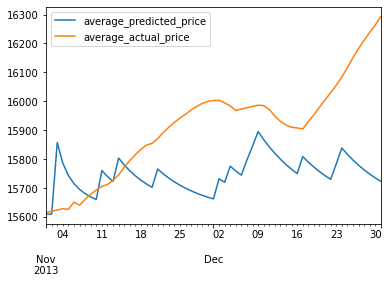

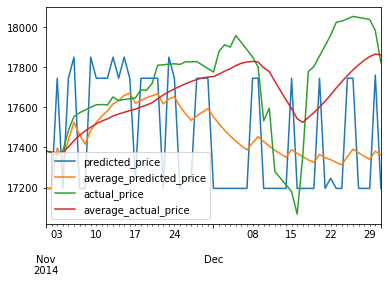

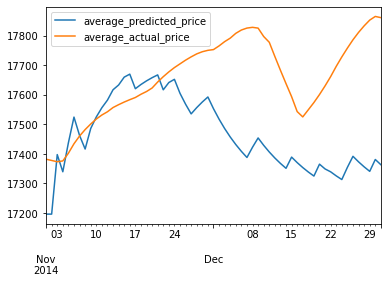

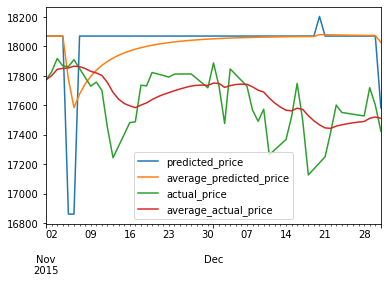

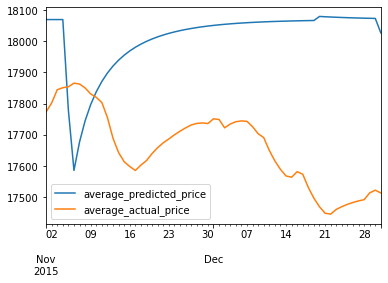

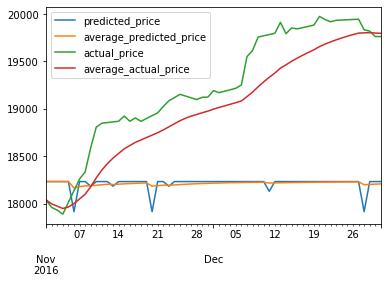

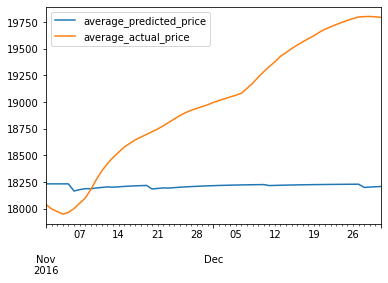

In [181]:
from sklearn.neural_network import MLPClassifier
from datetime import datetime, timedelta

# average_upcoming_5_days_predicted += predictions_df.loc[temp_date, 'prices']
# # Converting string to date time
# temp_date = datetime.strptime(temp_date, "%Y-%m-%d").date()
# # Adding one day from date time
# difference = temp_date + timedelta(days=1)
# # Converting again date time to string
# temp_date = difference.strftime('%Y-%m-%d')
        
# start_year = datetime.strptime(train_start_date, "%Y-%m-%d").date().month

years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
prediction_list = []
for year in years:
    # Splitting the training and testing data
    train_start_date = str(year) + '-01-01'
    train_end_date = str(year) + '-10-31'
    test_start_date = str(year) + '-11-01'
    test_end_date = str(year) + '-12-31'
    train = df.loc[train_start_date : train_end_date]
    test = df.loc[test_start_date:test_end_date]
    
    # Calculating the sentiment score
    sentiment_score_list = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list)
    sentiment_score_list = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
        #sentiment_score = np.asarray([df.loc[date, 'neg'],df.loc[date, 'pos']])
        sentiment_score_list.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list)
    
    # Generating models
    rf = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='relu', 
                         solver='adam', alpha=0.0001, learning_rate_init = 0.0001, shuffle=False) # span = 20 # best 1
    rf.fit(numpy_df_train, train['prices'])   
    prediction = rf.predict(numpy_df_test)    
    prediction_list.append(prediction)
    #print train_start_date + ' ' + train_end_date + ' ' + test_start_date + ' ' + test_end_date
    idx = pd.date_range(test_start_date, test_end_date)
    #print year
    predictions_df_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
    
    difference_test_predicted_prices = offset_value(test_start_date, test, predictions_df_list)
    # Adding offset to all the advpredictions_df price values
    predictions_df_list['prices'] = predictions_df_list['prices'] + difference_test_predicted_prices
    predictions_df_list

    # Smoothing the plot
    predictions_df_list['ewma'] = predictions_df_list["prices"].ewm(span=20).mean()
    predictions_df_list['actual_value'] = test['prices']
    predictions_df_list['actual_value_ewma'] = predictions_df_list["actual_value"].ewm(span=20).mean()
    # Changing column names
    predictions_df_list.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
    predictions_df_list.plot()
    predictions_df_list_average = predictions_df_list[['average_predicted_price', 'average_actual_price']]
    predictions_df_list_average.plot()
#   predictions_df_list.show()


In [182]:
prediction, bias, contributions = ti.predict(rf, numpy_df_train)
idx = pd.date_range(train_start_date, train_end_date)
predictions_df1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])
predictions_df1.plot() 
train['prices'].plot()

ValueError: Multilabel classification trees not supported